In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

from wordcloud import WordCloud

import nltk
print(nltk.__version__)

nltk.download('punkt')

# Downloading the 'stopwords' module that will be helpful for Stopwrods removal
nltk.download('stopwords')

# Downloading the 'wordnet' module that will be helpful for stemming and lemmatization
nltk.download('wordnet')

# Downloading the 'omw1.4', dependency for Tokenization
nltk.download('omw-1.4')

# Downloading the 'averaged_perceptron_tagger' for POS_Tagging
nltk.download('averaged_perceptron_tagger')

# Downloading  the required modules that are used in NER tagging
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.corpus import stopwords

# Helpful in Lemmatization
from nltk.stem import WordNetLemmatizer

# Helpful in Tokenization
from nltk.tokenize import word_tokenize, sent_tokenize

# Used in Stemming
from nltk.stem.porter import PorterStemmer


# Used in NER Tagging
from nltk.corpus import treebank_chunk
from nltk.chunk import ne_chunk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer


from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

3.2.4
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\A462766\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
data = pd.read_json(r'C:\Personal\AI\NLP\Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [4]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [5]:
df_sarcastic = data.is_sarcastic.value_counts().to_frame()
df_sarcastic

,is_sarcastic
0,14985
1,13634


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

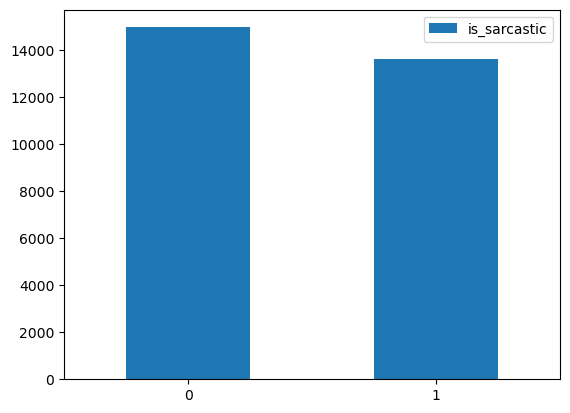

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
df_sarcastic.plot(kind = 'bar')
plt.xticks(rotation = 0)


In [7]:
print(f'Is Sarcastic count: {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

Is Sarcastic count: 48.0%
Isn't Sarcastic count: 52.0%


In [8]:
sarcastic_headlines = data.loc[data['is_sarcastic'] == 1]
non_sarcastic_headlines = data.loc[data['is_sarcastic'] == 0].sample(n = 11724, random_state = 25)

In [9]:
text = ' '.join(review for review in sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text)))

There are 904356 words in the combination of all review.


In [10]:
print('--'*30);
print('Checking 5 random headlines and labels from the data');
print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])
dataval = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: robert pattinson looking forward to taking on more serious vampire roles after conclusion of 'twilight' films
label: 1

Headline: man pinned under blankets for three days
label: 1

Headline: every tomboy's guide to being a modern lady
label: 0

Headline: this group is bringing tampons and pads to evacuees in louisiana
label: 0

Headline: excited nation already lining up outside irs offices in anticipation of tax day
label: 1



In [11]:
text = ' '.join(review for review in sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text)))

There are 904356 words in the combination of all review.


(-0.5, 399.5, 199.5, -0.5)

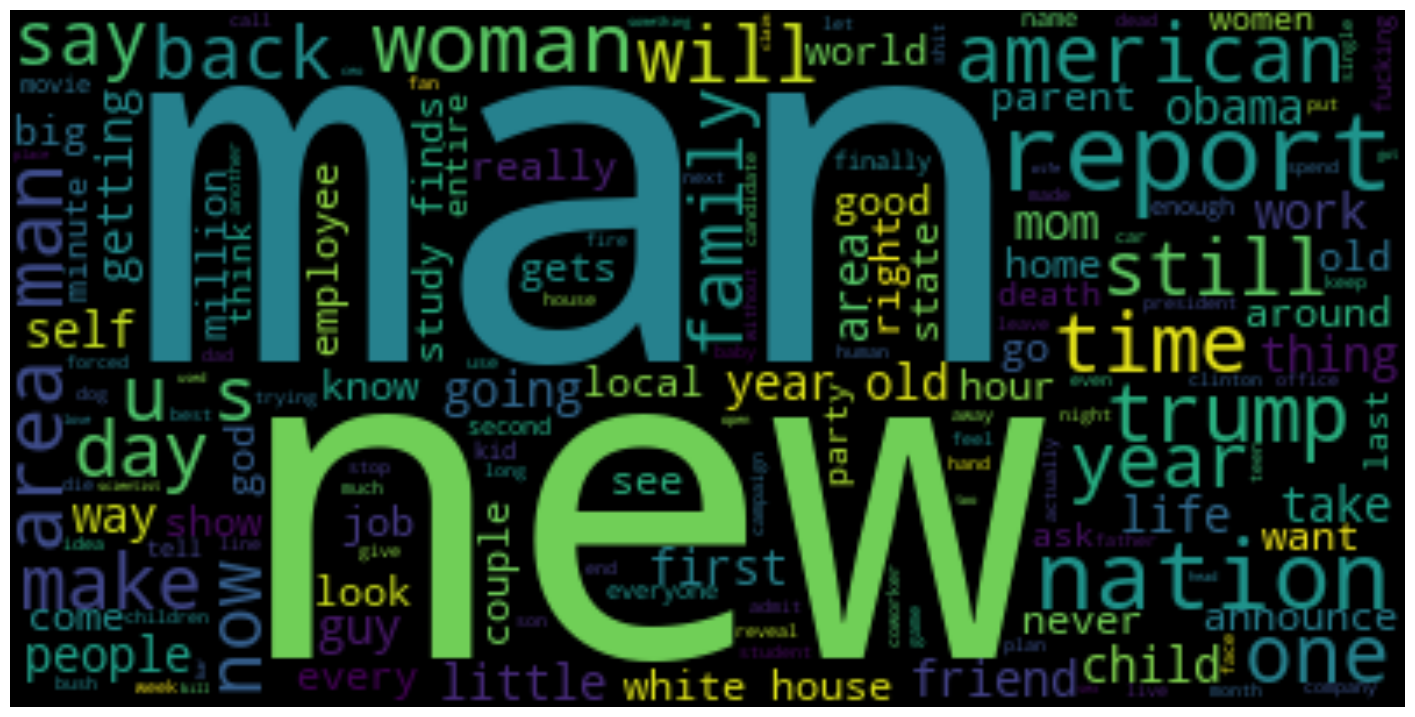

In [12]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(text)

plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [13]:
text_ns = ' '.join(review for review in non_sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text_ns)))

There are 709999 words in the combination of all review.


(-0.5, 399.5, 199.5, -0.5)

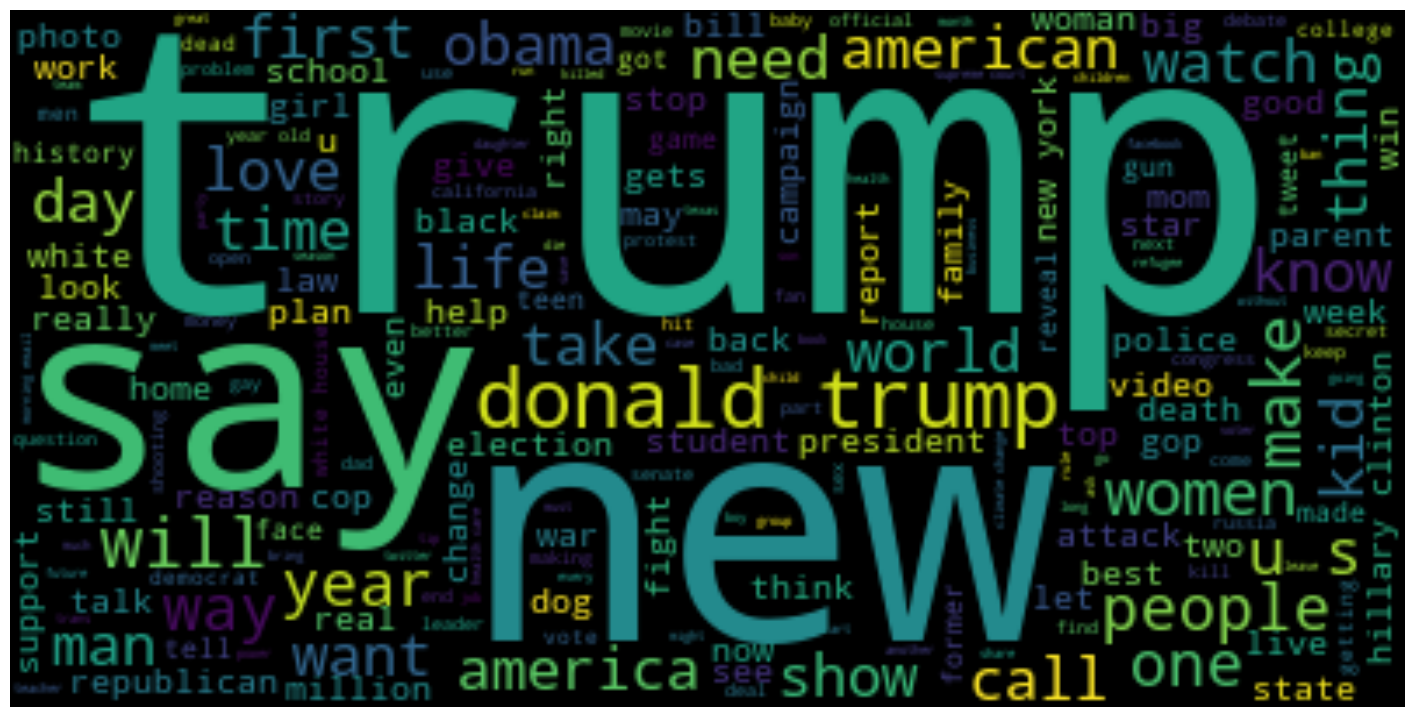

In [14]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(text_ns)

plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [15]:
data = data.drop(columns = 'article_link', axis = 1)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [16]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [17]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [18]:
clean_balanced_headlines = []
for headline in data['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = False))
print('Data is cleaned!')

Data is cleaned!


In [19]:
data['cleaned_headline'] = clean_balanced_headlines
data.head()

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word strea...


In [20]:
max_length = max([len(headline.split()) for headline in data['cleaned_headline']])
print('Maximum Length: ', max_length)

Maximum Length:  152


In [21]:
max_features = 10000
maxlen = max_length
embedding_size = 200

In [22]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data['cleaned_headline'])

In [23]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 28619
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  359 3198 6352 2176    2  651 1142]
Number of Labels:  28619
1


In [24]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  26423


In [25]:
from zipfile import ZipFile
with ZipFile(r'C:\Personal\AI\NLP\glove.6B.zip') as z:
  z.extractall()

In [26]:
embeddings = {}
for o in open(r'C:\Personal\AI\NLP\glove.6B.200d.txt',encoding="utf8"):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [27]:
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 152
Number of unique words in training dataset: 9989
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 152
Number of unique words in test dataset: 7898


In [29]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 152, 200)          2000200   
                                                                 
 bidirectional (Bidirection  (None, 152, 256)          336896    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [30]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/6

Epoch 1: val_loss improved from inf to 0.44680, saving model to sarcasm_detector.h5
184/184 - 609s - loss: 0.5996 - accuracy: 0.6655 - val_loss: 0.4468 - val_accuracy: 0.8085 - lr: 0.0010 - 609s/epoch - 3s/step
Epoch 2/6

Epoch 2: val_loss improved from 0.44680 to 0.40647, saving model to sarcasm_detector.h5
184/184 - 876s - loss: 0.4738 - accuracy: 0.7842 - val_loss: 0.4065 - val_accuracy: 0.8181 - lr: 0.0010 - 876s/epoch - 5s/step
Epoch 3/6

Epoch 3: val_loss improved from 0.40647 to 0.35685, saving model to sarcasm_detector.h5
184/184 - 859s - loss: 0.3844 - accuracy: 0.8340 - val_loss: 0.3569 - val_accuracy: 0.8388 - lr: 0.0010 - 859s/epoch - 5s/step
Epoch 4/6

Epoch 4: val_loss improved from 0.35685 to 0.35471, saving model to sarcasm_detector.h5
184/184 - 874s - loss: 0.3436 - accuracy: 0.8573 - val_loss: 0.3547 - val_accuracy: 0.8428 - lr: 0.0010 - 874s/epoch - 5s/step
Epoch 5/6

Epoch 5: val_loss improved from 0.35471 to 0.33574, saving model to sarcasm_detector.h5
1

In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [36]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

179/179 [==============================] - 16s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      3286
           1       0.80      0.89      0.84      2438

    accuracy                           0.86      5724
   macro avg       0.85      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724



Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2733,262
Sarcastic,553,2176


------------------------------------------------------------


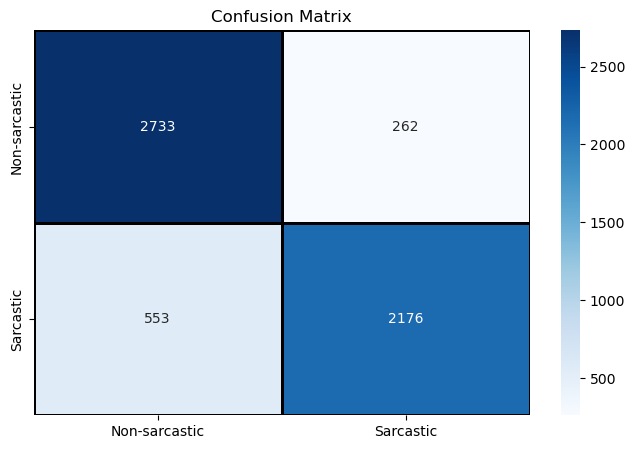

In [37]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')